In [45]:
# Data Loader
import os
import numpy as np
from random import shuffle
from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation, MaxPooling2D, BatchNormalization,\
                                    SpatialDropout2D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

In [46]:
def gen_labels(im_name, pat1, pat2):
    '''
    Parameters
    ----------
    im_name : Str
    The image file name.
    pat1 : Str
    A string pattern in the filename for 1st class, e.g "Mel"
    pat2 : Str
    A string pattern in the filename 2nd class, e.g, "Nev"
    Returns
    -------
    Label : Numpy array
    Class label of the filename name based on its pattern.
    '''
    if pat1 in im_name:
        label = np.array([0])
    elif pat2 in im_name:
        label = np.array([1])
    return label

def get_data(data_path, data_list, img_h, img_w):
    """
    Parameters
    ----------
    train_data_path : Str
    Path to the data directory
    train_list : List
    A list containing the name of the images.
    img_h : Int
    image height to be resized to.
    img_w : Int
    image width to be resized to.
    Returns
    -------
    img_labels : Nested List
    A nested list containing the loaded images along with their
    correcponding labels.
    """
    data_list_1 = os.listdir(os.path.join(data_path, 'Nevi'))
    data_list_2 = os.listdir(os.path.join(data_path, 'Mel'))
    
    img_labels = []
    for item in enumerate(data_list_1+data_list_2):
        if item[1] in data_list_1:
            img = imread(os.path.join(data_path,'Nevi', item[1]), as_gray = True) # "as_grey"
            img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
            img_labels.append([np.array(img), np.array([1])])
        else: 
            img = imread(os.path.join(data_path,'Mel', item[1]), as_gray = True) # "as_grey"
            img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
            img_labels.append([np.array(img), np.array([0])])
            
        if item[0] % 100 == 0:
            print('Reading: {0}/{1} of train images'.format(item[0], len(data_list_1+data_list_2)))
        
    shuffle(img_labels)
    return img_labels

def get_data_arrays(nested_list, img_h, img_w):
    """
    Parameters
    ----------
    nested_list : nested list
    nested list of image arrays with corresponding class labels.
    img_h : Int
    Image height.
    img_w : Int
    Image width.

    Returns
    -------
    img_arrays : Numpy array
    4D Array with the size of (n_data,img_h,img_w, 1)
    label_arrays : Numpy array
    1D array with the size (n_data).
    """
    img_arrays = np.zeros((len(nested_list), img_h, img_w), dtype = np.float32)
    label_arrays = np.zeros((len(nested_list)), dtype = np.int32)
    
    for ind in range(len(nested_list)):
        img_arrays[ind] = nested_list[ind][0]
        label_arrays[ind] = nested_list[ind][1]
    
    img_arrays = np.expand_dims(img_arrays, axis =3)    
    return img_arrays, label_arrays

def get_train_test_arrays(train_data_path, test_data_path, train_list,
                          test_list, img_h, img_w):
    """
    Get the directory to the train and test sets, the files names and
    the size of the image and return the image and label arrays for
    train and test sets.
    """
    train_data = get_data(train_data_path, train_list, img_h, img_w)
    test_data = get_data(test_data_path, test_list, img_h, img_w)
    train_img, train_label = get_data_arrays(train_data, img_h, img_w)
    test_img, test_label = get_data_arrays(test_data, img_h, img_w)
    del(train_data)
    del(test_data)
    return train_img, test_img, train_label, test_label

img_w, img_h = 128, 128 # Setting the width and heights of the images.
data_path = '/DL_course_data/Lab2/Skin/' # Path to data root with two subdirs.
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'validation')
train_list = os.listdir(train_data_path)
test_list = os.listdir(test_data_path)
x_train, x_validation, y_train, y_validation = get_train_test_arrays(train_data_path, test_data_path, train_list,
                                                         test_list, img_h, img_w)

Reading: 0/1000 of train images
Reading: 100/1000 of train images
Reading: 200/1000 of train images
Reading: 300/1000 of train images
Reading: 400/1000 of train images
Reading: 500/1000 of train images
Reading: 600/1000 of train images
Reading: 700/1000 of train images
Reading: 800/1000 of train images
Reading: 900/1000 of train images
Reading: 0/200 of train images
Reading: 100/200 of train images


In [6]:
# define function for visualization of learning curves:
def learning_curves(hist_name, loss_key, validation_loss_key, accuracy_key, validation_accuracy_key):
    plt.figure(figsize=(4, 4))
    plt.title("Learning curve")
    plt.plot(hist_name.history[loss_key], label=loss_key) #loss is training loss
    plt.plot(hist_name.history[validation_loss_key], label=validation_loss_key) #val_loss is validation loss
    plt.plot(np.argmin(hist_name.history[validation_loss_key]),
    np.min(hist_name.history[validation_loss_key]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.ylim((0,3))

    plt.legend();
    print(hist_name.history.keys())
    print("Training accuracy", hist_name.history[accuracy_key][-1])
    print("Validation accuracy", hist_name.history[validation_accuracy_key][-1])
    plt.show()

    # plotting accuracy curves
    plt.figure(figsize=(4, 4))
    plt.title("Learning curve")
    plt.plot(hist_name.history[accuracy_key], label=accuracy_key) # training accuracy
    plt.plot(hist_name.history[validation_accuracy_key], label=validation_accuracy_key) # validation accuracy
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim((0,1))
    return 

## Task1a) Employ the AlexNet model with the following architecture: five convolutional blocks [with feature maps of the size of base, base*2, base*4, base*4, base*2 where base=8], followed by three dense layers with 64, 64, and 1 neuron, respectively. Add three max-pooling layers after 1st, 2nd, and 5th convolutional blocks. Set the following parameters: learning rate=0.0001, batch size=8, ‘relu’ as activation function, ‘Adam’ as optimizer, and image size=(128,128,1). Train this model for 50 epochs on skin images. What are the values of the train and validation accuracy? How do you interpret the learning curves? Add two drop out layers after the first two dense layers with the dropout rate of 0.4 and repeat the experiments and compare the results. What is the effect of adding drop out layers?

In [3]:
def AlexNet(img_ch, img_width, img_height, base, dropout_rate):
    
    model = Sequential()
    
    model.add(Conv2D(filters=base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))

    model.add(Dense(64))
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model


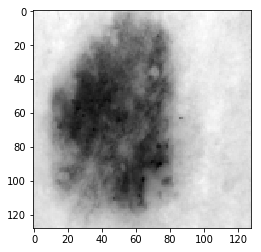

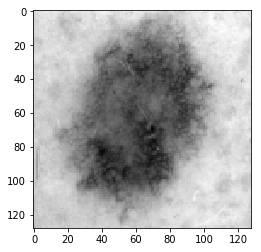

In [4]:
plt.imshow(x_train[10][:,:,0], cmap="gray")
plt.show()
plt.imshow(x_train[100][:,:,0], cmap="gray")
plt.show()

In [5]:
learning_rate=0.0001
batch_size=8
dropout_rate = 0 
epochs = 50
n_base = 8

clf_Alex_1a = AlexNet(1, 128, 128, n_base, dropout_rate)
clf_Alex_1a.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_Alex_1a_hist = clf_Alex_1a.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_validation, y_validation),
                                    shuffle=False,                                    
                                    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 8)       80        
_________________________________________________________________
activation (Activation)      (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4

dict_keys(['binary_accuracy', 'loss', 'val_loss', 'val_binary_accuracy'])
Training accuracy 0.955
Validation accuracy 0.77


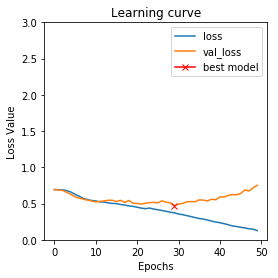

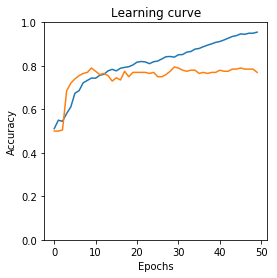

In [10]:
# visualize learning curves:
loss_key = 'loss'
val_loss_key = 'val_loss'
accuracy_key = 'binary_accuracy'
val_accuracy_key = 'val_binary_accuracy'
learning_curves(clf_Alex_1a_hist, loss_key, val_loss_key, accuracy_key, val_accuracy_key)

### How do you interpret the learning curves?
The learning curves diverge from each other. The validatoin loss is higher than the training loss. Thus, the network seems to overfit the data. Furthermore, the validation accuracy does not substantially increase after 10 epochs.

### Add two drop out layers after the first two dense layers with the dropout rate of 0.4 and repeat the experiments and compare the results. 

In [13]:
learning_rate=0.0001
batch_size=8
dropout_rate = 0.4 
epochs = 50
n_base = 8

clf_Alex_1a_do = AlexNet(1, 128, 128, n_base, dropout_rate)
clf_Alex_1a_do.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_Alex_1a_do_hist = clf_Alex_1a_do.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_validation, y_validation),
                                    shuffle=False,                                    
                                    )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_16 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_17 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)       

dict_keys(['binary_accuracy', 'loss', 'val_loss', 'val_binary_accuracy'])
Training accuracy 0.868
Validation accuracy 0.795


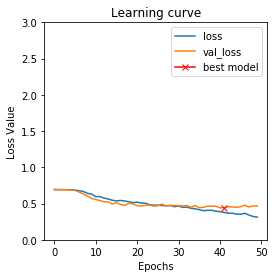

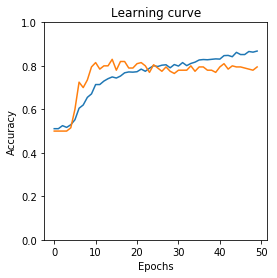

In [14]:
# visualize learning curves:
learning_curves(clf_Alex_1a_do_hist, loss_key, val_loss_key, accuracy_key, val_accuracy_key)

### What is the effect of adding drop out layers?
Adding the dropout reduces the overfitting. This can be seen by the decreased difference between the training and validation loss in the final epochs. However, compared to the model without dropout, the validation accuracy is lower. But overall, the generalization power of the model seems to be higher.  

## Task1b) With the same model and same settings, now insert a batch normalization layer at each convolutional block (right after convolution layer and before activation function). At which epoch do you observe the same training accuracy as task1a? What is the value of final training accuracy? What is the effect of the batch normalization layer? Similar to task1a, do this task with and without drop out layers.

In [17]:
def AlexNet_1b(img_ch, img_width, img_height, base, dropout_rate):
    
    model = Sequential()
    
    model.add(Conv2D(filters=base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters=base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters=base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))

    model.add(Dense(64))
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
batch_normalization_v2_15 (B (None, 128, 128, 8)       32        
_________________________________________________________________
activation_48 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
batch_normalization_v2_16 (B (None, 64, 64, 16)        64        
_________________________________________________________________
activation_49 (Activation)   (None, 64, 64, 16)       

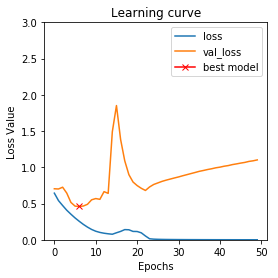

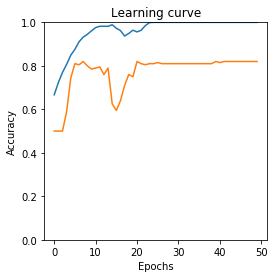

In [21]:
# test model w/o dropout
dropout_rate = 0
clf_Alex_1b = AlexNet_1b(1, 128, 128, n_base, dropout_rate)
clf_Alex_1b.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_Alex_1b_hist = clf_Alex_1b.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_validation, y_validation),
                                    shuffle=False,                                    
                                    )

# visualize learning curves:
learning_curves(clf_Alex_1b_hist, loss_key, val_loss_key, accuracy_key, val_accuracy_key)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
batch_normalization_v2_20 (B (None, 128, 128, 8)       32        
_________________________________________________________________
activation_56 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
batch_normalization_v2_21 (B (None, 64, 64, 16)        64        
_________________________________________________________________
activation_57 (Activation)   (None, 64, 64, 16)       

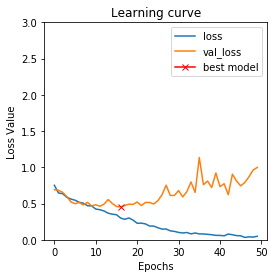

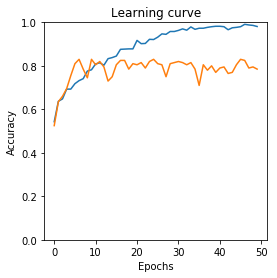

In [22]:
# test model with dropout and batch norm
dropout_rate = 0.4
clf_Alex_1b_do = AlexNet_1b(1, 128, 128, n_base, dropout_rate)
clf_Alex_1b_do.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_Alex_1b_do_hist = clf_Alex_1b_do.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_validation, y_validation),
                                    shuffle=False,                                    
                                    )

# visualize learning curves:
learning_curves(clf_Alex_1b_do_hist, loss_key, val_loss_key, accuracy_key, val_accuracy_key)

### At which epoch do you observe the same training accuracy as task1a? What is the value of final training accuracy? What is the effect of the batch normalization layer? Similar to task1a, do this task with and without drop out layers.¶

- Model without dropout: After 10 epochs, the network with Batch Normalization achieved the same training accuracy as the model without Batch Normalization. The final training accuracy is 1 for the model with Batch Normalization.

- Model with dopout: After 17 epochs, the model with dropout and Batch Normalization reaches the same training accuracy as he model with dropout and without Batch Normalization. The final training accuracy of the model with dropout is 0.981.

Therefore, the Batch normalization sped-up training process in both cases, but did not affect the validation accuracy substantially. 

## Task1c) Train again the same model with precisely the same parameters except learning rate = 0.00001 and epochs = 80 with and without batch normalization layers (in bose cases, use the drop out layers). Focus on validation loss & accuracy. Which model resulted in higher validation accuracy? How do you explain the effect of batch normalization?


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_64 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_65 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 32)       

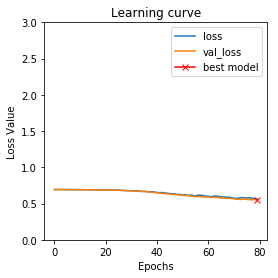

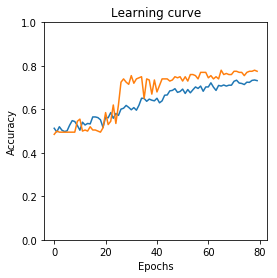

In [23]:
# Model without batch norm
dropout_rate = 0.4
learning_rate=0.00001
batch_size=8
epochs = 80
n_base = 8

clf_Alex_1c = AlexNet(1, 128, 128, n_base, dropout_rate)
clf_Alex_1c.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_Alex_1c_hist = clf_Alex_1c.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_validation, y_validation),
                                    shuffle=False,                                    
                                    )

# visualize learning curves:
learning_curves(clf_Alex_1c_hist, loss_key, val_loss_key, accuracy_key, val_accuracy_key)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
batch_normalization_v2_25 (B (None, 128, 128, 8)       32        
_________________________________________________________________
activation_72 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
batch_normalization_v2_26 (B (None, 64, 64, 16)        64        
_________________________________________________________________
activation_73 (Activation)   (None, 64, 64, 16)       

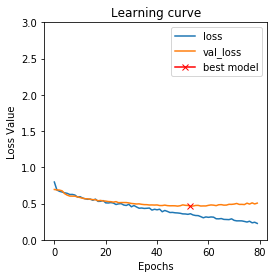

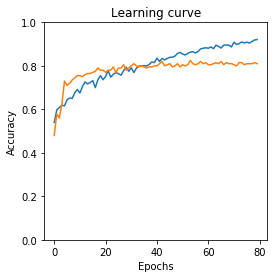

In [24]:
# Model with Batch Norm
dropout_rate = 0.4
learning_rate=0.00001
batch_size=8
epochs = 80
n_base = 8

clf_Alex_1c_bn = AlexNet_1b(1, 128, 128, n_base, dropout_rate)
clf_Alex_1c_bn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_Alex_1c_bn_hist = clf_Alex_1c_bn.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_validation, y_validation),
                                    shuffle=False,                                    
                                    )

# visualize learning curves:
learning_curves(clf_Alex_1c_bn_hist, loss_key, val_loss_key, accuracy_key, val_accuracy_key)

### Focus on validation loss & accuracy. Which model resulted in higher validation accuracy? How do you explain the effect of batch normalization?

The model with Batch Normalization resulted in a highrt validation accuracy (0.81 vs. 0.78). The model with Batch Normalization also has slightly lower loss than the model without Batch Normalization. Furthermore, the validation accuracy converges faster when using the Batch Normalization. 

## Task1d) Keep the settings from the task1c unchanged and train the model for 150 epochs with and without batch normalization layers (in bose cases, use the drop out layers). Which model yields more accurate results? Which of them has more generalization power?


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_80 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_81 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 32, 32)      

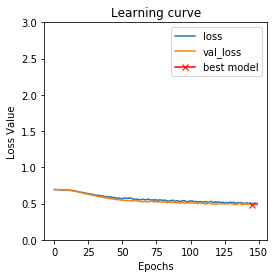

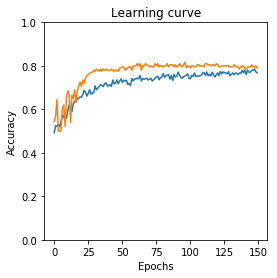

In [25]:
# Model without batch norm
dropout_rate = 0.4
learning_rate=0.00001
batch_size=8
epochs = 150
n_base = 8

clf_Alex_1d = AlexNet(1, 128, 128, n_base, dropout_rate)
clf_Alex_1d.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_Alex_1d_hist = clf_Alex_1d.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_validation, y_validation),
                                    shuffle=False,                                    
                                    )

# visualize learning curves:
learning_curves(clf_Alex_1d_hist, loss_key, val_loss_key, accuracy_key, val_accuracy_key)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
batch_normalization_v2_30 (B (None, 128, 128, 8)       32        
_________________________________________________________________
activation_88 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
batch_normalization_v2_31 (B (None, 64, 64, 16)        64        
_________________________________________________________________
activation_89 (Activation)   (None, 64, 64, 16)      

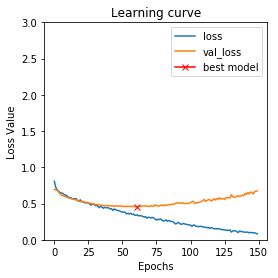

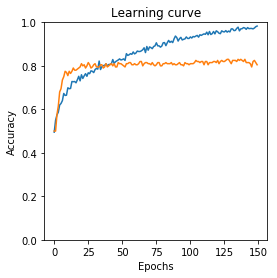

In [26]:
# Model with Batch Norm
dropout_rate = 0.4
learning_rate=0.00001
batch_size=8
epochs = 150
n_base = 8

clf_Alex_1d_bn = AlexNet_1b(1, 128, 128, n_base, dropout_rate)
clf_Alex_1d_bn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_Alex_1d_bn_hist = clf_Alex_1d_bn.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_validation, y_validation),
                                    shuffle=False,                                    
                                    )

# visualize learning curves:
learning_curves(clf_Alex_1d_bn_hist, loss_key, val_loss_key, accuracy_key, val_accuracy_key)

### Which model yields more accurate results? Which of them has more generalization power?

The model with batch normalization yiels a slightly better validation accuracy. (0.81 vs. 0.79) Thus, this model is more accurate. However, the difference between the training and valiation loss is higher than in the model without batch normalization. Thus, the model without batch normalization has the higher generalization power. 

## Task2a) Use the same model as task1d but set the “base” parameter as 32 and replace the batch normalization layers with spatial dropout layers at each convolutional blocks (after activation function, and before max-pooling). Set the dropout rate of spatial drop out layers as 0.1 and the rate of 0.4 for the normal drop out layers after the first two fully connected layers. Then let the model runs for 150 epochs with LR=0.00001. Save the loss and accuracy values for the validation data. Then, run the same model with the same settings but remove all the spatial drop out layers. Which of them converges faster? Why?

In [28]:
def AlexNet_2a(img_ch, img_width, img_height, base, dropout_rate, spatial_dropout_rate):
    
    model = Sequential()
    
    model.add(Conv2D(filters=base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(SpatialDropout2D(spatial_dropout_rate))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(SpatialDropout2D(spatial_dropout_rate))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(SpatialDropout2D(spatial_dropout_rate))

    model.add(Conv2D(filters=base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(SpatialDropout2D(spatial_dropout_rate))

    model.add(Conv2D(filters=base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(SpatialDropout2D(spatial_dropout_rate))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))

    model.add(Dense(64))
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
activation_96 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_97 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 64, 64, 64)      

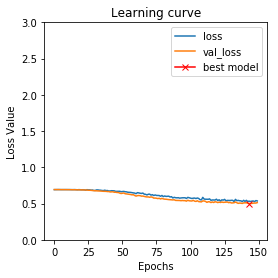

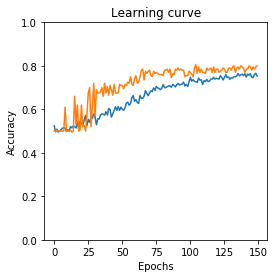

In [30]:
# Model with spatial dropout
dropout_rate = 0.4
spatial_dropout_rate = 0.1
learning_rate=0.00001
batch_size=8
epochs = 150
n_base = 32

clf_Alex_2a = AlexNet_2a(1, 128, 128, n_base, dropout_rate, spatial_dropout_rate)
clf_Alex_2a.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_Alex_2a_hist = clf_Alex_2a.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_validation, y_validation),
                                    shuffle=False,                                    
                                    )

# visualize learning curves:
learning_curves(clf_Alex_2a_hist, loss_key, val_loss_key, accuracy_key, val_accuracy_key)

In [32]:
def AlexNet_2a_2(img_ch, img_width, img_height, base, dropout_rate, spatial_dropout_rate):
    
    model = Sequential()
    
    model.add(Conv2D(filters=base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    #model.add(SpatialDropout2D(spatial_dropout_rate))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    #model.add(SpatialDropout2D(spatial_dropout_rate))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    #model.add(SpatialDropout2D(spatial_dropout_rate))

    model.add(Conv2D(filters=base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    #model.add(SpatialDropout2D(spatial_dropout_rate))

    model.add(Conv2D(filters=base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    #model.add(SpatialDropout2D(spatial_dropout_rate))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))

    model.add(Dense(64))
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
activation_104 (Activation)  (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_105 (Activation)  (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 32, 32, 128)     

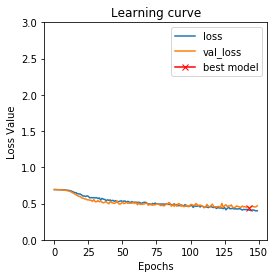

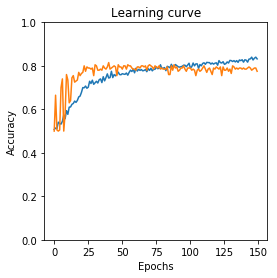

In [33]:
#Same Model without spatial dropout

clf_Alex_2a_2 = AlexNet_2a_2(1, 128, 128, n_base, dropout_rate, spatial_dropout_rate)
clf_Alex_2a_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_Alex_2a_2_hist = clf_Alex_2a_2.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_validation, y_validation),
                                    shuffle=False,                                    
                                    )

# visualize learning curves:
learning_curves(clf_Alex_2a_2_hist, loss_key, val_loss_key, accuracy_key, val_accuracy_key)

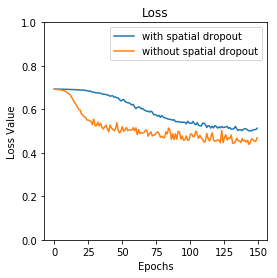

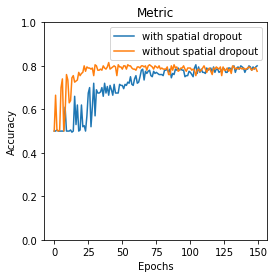

In [43]:
# visualizing validation data of both cases side-by-side in one plot    
plt.figure(figsize=(4, 4))
plt.title("Loss")
plt.plot(clf_Alex_2a_hist.history['val_loss'], label='with spatial dropout') #loss with Spatial Dropout
plt.plot(clf_Alex_2a_2_hist.history['val_loss'], label='without spatial dropout') #loss withput Spatial Dropout
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1))
plt.legend();

plt.figure(figsize=(4, 4))
plt.title("Metric")
plt.plot(clf_Alex_2a_hist.history['val_binary_accuracy'], label='with spatial dropout') #Accuracy w/ spatial DO
plt.plot(clf_Alex_2a_2_hist.history['val_binary_accuracy'], label='without spatial dropout') #Accuracy w/o spatial DO
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim((0,1))
plt.legend();

### Then, run the same model with the same settings but remove all the spatial drop out layers. Which of them converges faster? Why?

The Model with Spatial Dropout converges slower than the model without. Since dropping the channels in the kernel makes the optimization more difficult(because it removes parameters that are helpful for the classification), the model needs more training epochs to achieve the same classification performance. 

## Task2b) Repeat the task2a for 250 epochs with and without spatial dropout layers. In general, discuss how the drop out technique (spatial and normal one) would help the learning procedure. 

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
activation_120 (Activation)  (None, 128, 128, 32)      0         
_________________________________________________________________
spatial_dropout2d_10 (Spatia (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_121 (Activation)  (None, 64, 64, 64)        0         
_________________________________________________________________
spatial_dropout2d_11 (Spatia (None, 64, 64, 64)      

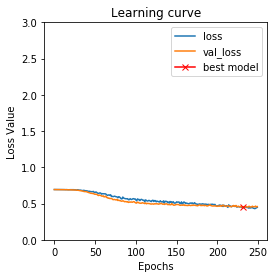

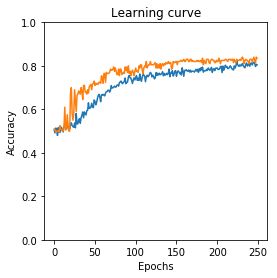

In [37]:
# Model with spatial dropout
dropout_rate = 0.4
spatial_dropout_rate = 0.1
learning_rate=0.00001
batch_size=8
epochs = 250
n_base = 32

clf_Alex_2b = AlexNet_2a(1, 128, 128, n_base, dropout_rate, spatial_dropout_rate)
clf_Alex_2b.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_Alex_2b_hist = clf_Alex_2b.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_validation, y_validation),
                                    shuffle=False,                                    
                                    )

# visualize learning curves:
learning_curves(clf_Alex_2b_hist, loss_key, val_loss_key, accuracy_key, val_accuracy_key)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
activation_128 (Activation)  (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_129 (Activation)  (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 32, 32, 128)     

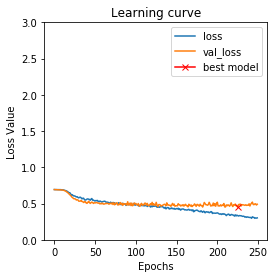

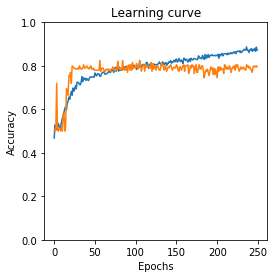

In [38]:
#Same Model without spatial dropout

clf_Alex_2b_2 = AlexNet_2a_2(1, 128, 128, n_base, dropout_rate, spatial_dropout_rate)
clf_Alex_2b_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_Alex_2b_2_hist = clf_Alex_2b_2.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_validation, y_validation),
                                    shuffle=False,                                    
                                    )

# visualize learning curves:
learning_curves(clf_Alex_2b_2_hist, loss_key, val_loss_key, accuracy_key, val_accuracy_key)

### In general, discuss how the drop out technique (spatial and normal one) would help the learning procedure.

Dropout helps the network learn to not rely only on specific features. Thereby, it regularizes the network and reduces overfitting. 